# IMPORT LIBRARY

In [1]:
import numpy as np
from sklearn import datasets as dt
import matplotlib.pyplot as plt
from time import time 
from matplotlib.collections import LineCollection
import pandas as pd

#KMEANS

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys

#Afinity Propagation

from sklearn import cluster, covariance, manifold

#Mean shift

from sklearn.cluster import MeanShift, estimate_bandwidth

#Spectal Clustering

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

#Hierarchial Clustering

from sklearn import manifold
import scipy.ndimage

#DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#OPTICS

from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

# DBSCAN

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


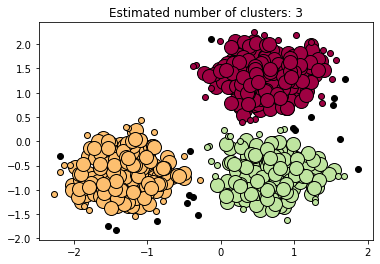

In [16]:
# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## Low-level Parallelism (Clustering handwritten digits)

In [2]:
#Load Dataset

data, labels = dt.load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [3]:
#Fungsi evaluation benchmark

def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [4]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.216s	69662	0.680	0.719	0.699	0.570	0.695	0.165
random   	0.138s	69707	0.675	0.716	0.694	0.560	0.691	0.160
PCA-based	0.047s	74152	0.653	0.683	0.668	0.539	0.664	0.146
__________________________________________________________________________________


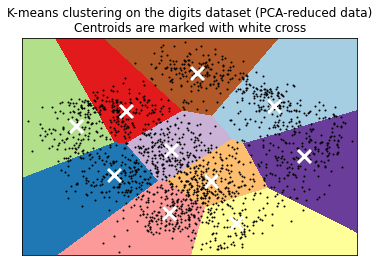

In [5]:
#Visualisasi Hasil 

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Mini Batch K-Means

### Comparison of the K-Means and MiniBatchKMeans clustering algorithms

In [6]:
# Generate sample data
np.random.seed(0)
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

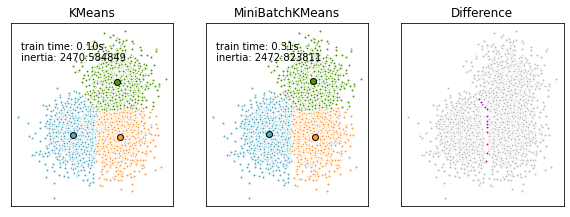

In [7]:
# #############################################################################
# Compute clustering with Means

k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
t0 = time()
k_means.fit(X)
t_batch = time() - t0

# #############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0

# #############################################################################
# Plot result

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()

### Clustering text documents using k-means

In [8]:
data2 = dt.fetch_20newsgroups
data2

<function sklearn.datasets._twenty_newsgroups.fetch_20newsgroups(*, data_home=None, subset='train', categories=None, shuffle=True, random_state=42, remove=(), download_if_missing=True, return_X_y=False)>

In [9]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# parse commandline arguments
op = OptionParser()
op.add_option(
    "--lsa",
    dest="n_components",
    type="int",
    help="Preprocess documents with latent semantic analysis.",
)
op.add_option(
    "--no-minibatch",
    action="store_false",
    dest="minibatch",
    default=True,
    help="Use ordinary k-means algorithm (in batch mode).",
)
op.add_option(
    "--no-idf",
    action="store_false",
    dest="use_idf",
    default=True,
    help="Disable Inverse Document Frequency feature weighting.",
)
op.add_option(
    "--use-hashing",
    action="store_true",
    default=False,
    help="Use a hashing feature vectorizer",
)
op.add_option(
    "--n-features",
    type=int,
    default=10000,
    help="Maximum number of features (dimensions) to extract from text.",
)
op.add_option(
    "--verbose",
    action="store_true",
    dest="verbose",
    default=False,
    help="Print progress reports inside k-means algorithm.",
)

print(__doc__)
op.print_help()
print()


def is_interactive():
    return not hasattr(sys.modules["__main__"], "__file__")


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset_clust = data2(
    subset="all", categories=categories, shuffle=True, random_state=42
)

print("%d documents" % len(dataset_clust.data))
print("%d categories" % len(dataset_clust.target_names))
print()

labels = dataset_clust.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm=None,
        )
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm="l2",
        )
else:
    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=opts.n_features,
        min_df=2,
        stop_words="english",
        use_idf=opts.use_idf,
    )
X = vectorizer.fit_transform(dataset_clust.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print(
        "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
    )

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(
        n_clusters=true_k,
        init="k-means++",
        n_init=1,
        init_size=1000,
        batch_size=1000,
        verbose=opts.verbose,
    )
else:
    km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=100,
        n_init=1,
        verbose=opts.verbose,
    )

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, km.labels_, sample_size=1000)
)

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names_out()
    for i in range(true_k):
        print("Cluster %d:" % i, end="")
        for ind in order_centroids[i, :10]:
            print(" %s" % terms[ind], end="")
        print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 2.195001s
n_samples: 3387, n_features: 10000

Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_si

### Visualizing the stock market structure

In [10]:
# #############################################################################
# Retrieve the data from Internet

# The data is from 2003 - 2008. This is reasonably calm: (not too long ago so
# that we get high-tech firms, and before the 2008 crash). This kind of
# historical data can be obtained for from APIs like the quandl.com and
# alphavantage.co ones.

symbol_dict = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
    "MSFT": "Microsoft",
    "IBM": "IBM",
    "TWX": "Time Warner",
    "CMCSA": "Comcast",
    "CVC": "Cablevision",
    "YHOO": "Yahoo",
    "DELL": "Dell",
    "HPQ": "HP",
    "AMZN": "Amazon",
    "TM": "Toyota",
    "CAJ": "Canon",
    "SNE": "Sony",
    "F": "Ford",
    "HMC": "Honda",
    "NAV": "Navistar",
    "NOC": "Northrop Grumman",
    "BA": "Boeing",
    "KO": "Coca Cola",
    "MMM": "3M",
    "MCD": "McDonald's",
    "PEP": "Pepsi",
    "K": "Kellogg",
    "UN": "Unilever",
    "MAR": "Marriott",
    "PG": "Procter Gamble",
    "CL": "Colgate-Palmolive",
    "GE": "General Electrics",
    "WFC": "Wells Fargo",
    "JPM": "JPMorgan Chase",
    "AIG": "AIG",
    "AXP": "American express",
    "BAC": "Bank of America",
    "GS": "Goldman Sachs",
    "AAPL": "Apple",
    "SAP": "SAP",
    "CSCO": "Cisco",
    "TXN": "Texas Instruments",
    "XRX": "Xerox",
    "WMT": "Wal-Mart",
    "HD": "Home Depot",
    "GSK": "GlaxoSmithKline",
    "PFE": "Pfizer",
    "SNY": "Sanofi-Aventis",
    "NVS": "Novartis",
    "KMB": "Kimberly-Clark",
    "R": "Ryder",
    "GD": "General Dynamics",
    "RTN": "Raytheon",
    "CVS": "CVS",
    "CAT": "Caterpillar",
    "DD": "DuPont de Nemours",
}


Fetching quote history for 'AAPL'
Fetching quote history for 'AIG'
Fetching quote history for 'AMZN'
Fetching quote history for 'AXP'
Fetching quote history for 'BA'
Fetching quote history for 'BAC'
Fetching quote history for 'CAJ'
Fetching quote history for 'CAT'
Fetching quote history for 'CL'
Fetching quote history for 'CMCSA'
Fetching quote history for 'COP'
Fetching quote history for 'CSCO'
Fetching quote history for 'CVC'
Fetching quote history for 'CVS'
Fetching quote history for 'CVX'
Fetching quote history for 'DD'
Fetching quote history for 'DELL'
Fetching quote history for 'F'
Fetching quote history for 'GD'
Fetching quote history for 'GE'
Fetching quote history for 'GS'
Fetching quote history for 'GSK'
Fetching quote history for 'HD'
Fetching quote history for 'HMC'
Fetching quote history for 'HPQ'
Fetching quote history for 'IBM'
Fetching quote history for 'JPM'
Fetching quote history for 'K'
Fetching quote history for 'KMB'
Fetching quote history for 'KO'
Fetching quote h

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Comcast, Cablevision, Time Warner
Cluster 3: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 4: Cisco, Dell, HP, IBM, Microsoft, SAP, Texas Instruments
Cluster 5: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 6: AIG, American express, Bank of America, Caterpillar, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, Marriott, 3M, Ryder, Wells Fargo, Wal-Mart
Cluster 7: McDonald's
Cluster 8: GlaxoSmithKline, Novartis, Pfizer, Sanofi-Aventis, Unilever
Cluster 9: Kellogg, Coca Cola, Pepsi
Cluster 10: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 11: Canon, Honda, Navistar, Sony, Toyota, Xerox


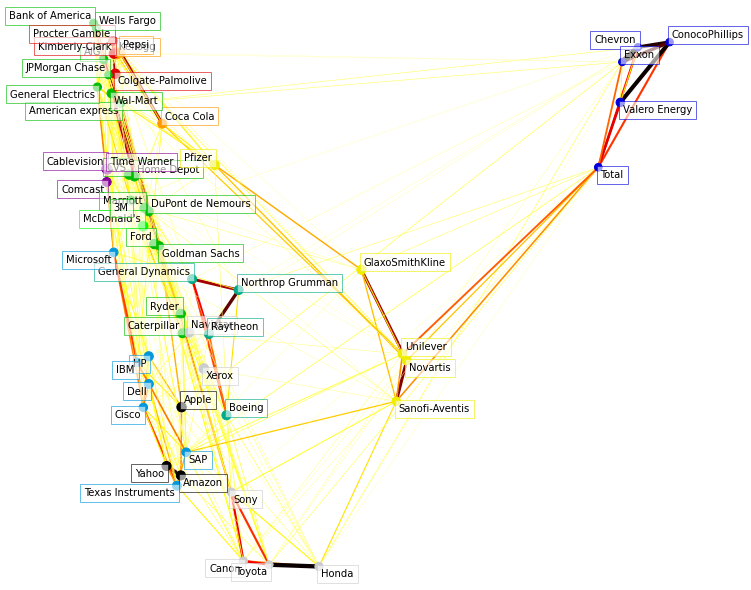

In [11]:
symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    print("Fetching quote history for %r" % symbol, file=sys.stderr)
    url = (
        "https://raw.githubusercontent.com/scikit-learn/examples-data/"
        "master/financial-data/{}.csv"
    )
    quotes.append(pd.read_csv(url.format(symbol)))

close_prices = np.vstack([q["close"] for q in quotes])
open_prices = np.vstack([q["open"] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print("Cluster %i: %s" % ((i + 1), ", ".join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

# #############################################################################
# Visualization
plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d ** 2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()

In [12]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

number of estimated clusters : 3


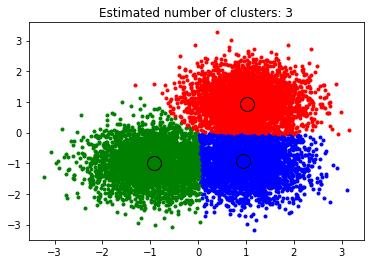

In [13]:
# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

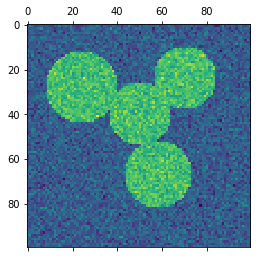

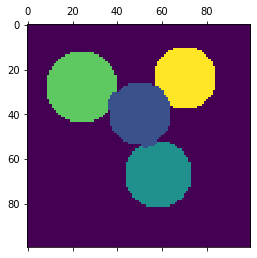

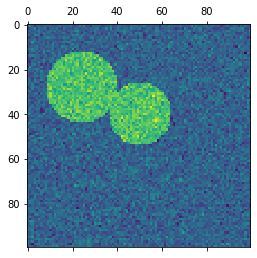

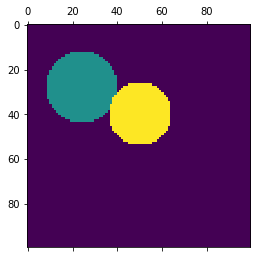

In [14]:

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

# #############################################################################
# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

plt.show()

### Different linkage type: Ward, complete, average, and single linkage

Computing embedding
Done.
ward :	0.52s
average :	0.75s
complete :	0.40s
single :	0.14s


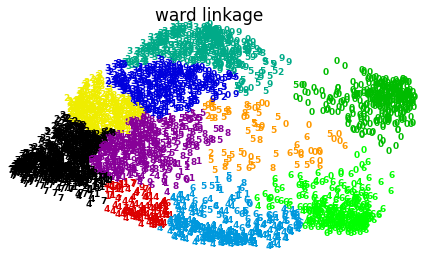

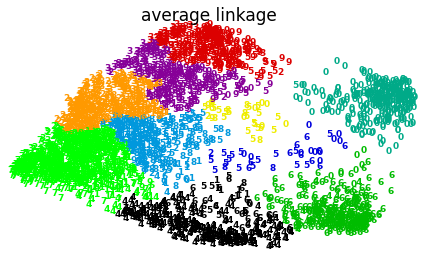

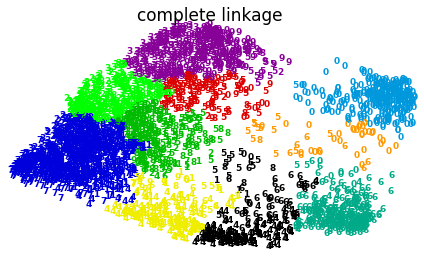

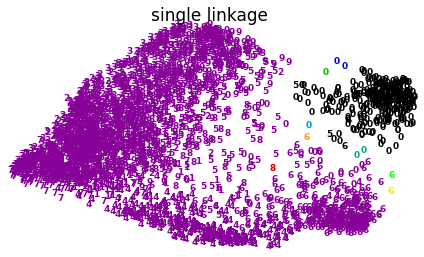

In [15]:
data_hierar = dt.load_digits

X, y = data_hierar(return_X_y=True)

n_samples, n_features = X.shape

np.random.seed(0)


def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: scipy.ndimage.shift(
        x.reshape((8, 8)), 0.3 * np.random.normal(size=2), mode="constant"
    ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


X, y = nudge_images(X, y)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(
            X_red[i, 0],
            X_red[i, 1],
            str(y[i]),
            color=plt.cm.nipy_spectral(labels[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()